In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import argparse
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pokemon_df = pd.read_csv('pokemon.csv')
combats_df = pd.read_csv('combats.csv')
test_df = pd.read_csv('tests.csv')
prediction_df = test_df.copy()

In [3]:
pokemon_df['Type 2'] = pokemon_df['Type 2'].fillna('None')
pokemon_df['Type 1'] = pokemon_df['Type 1'].replace('Fighting', 'Fight')
pokemon_df['Type 2'] = pokemon_df['Type 2'].replace('Fighting', 'Fight')
pokemon_df['Legendary'] = pokemon_df['Legendary'].map({False: 0, True:1})

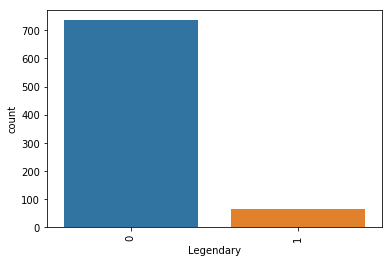

In [4]:
sns.countplot(x='Legendary', data=pokemon_df, order=pokemon_df['Legendary'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

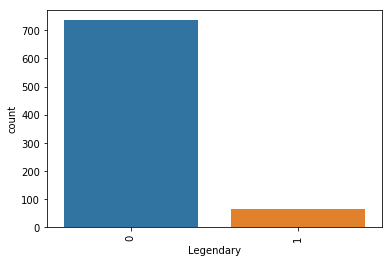

In [5]:
sns.countplot(x='Legendary', data=pokemon_df, order=pokemon_df['Legendary'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

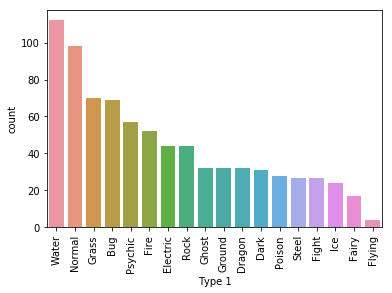

In [6]:
sns.countplot(x='Type 1', data=pokemon_df, order=pokemon_df['Type 1'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

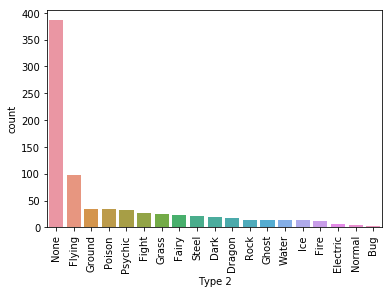

In [7]:
sns.countplot(x='Type 2', data=pokemon_df, order=pokemon_df['Type 2'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

1    166
5    165
3    160
4    121
2    106
6     82
Name: Generation, dtype: int64


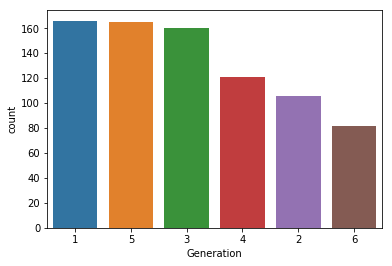

In [8]:
print(pokemon_df['Generation'].value_counts())

sns.countplot(x='Generation', data=pokemon_df, order=pokemon_df['Generation'].value_counts().index)
plt.show()

In [9]:
pokemon_df['Total_stats'] = pokemon_df['HP'] + pokemon_df['Attack'] + pokemon_df['Defense'] + pokemon_df['Sp. Atk'] + pokemon_df['Sp. Def'] + pokemon_df['Speed']
print(pokemon_df.iloc[:, [1, -1]].head())

            Name  Total_stats
0      Bulbasaur          318
1        Ivysaur          405
2       Venusaur          525
3  Mega Venusaur          625
4     Charmander          309


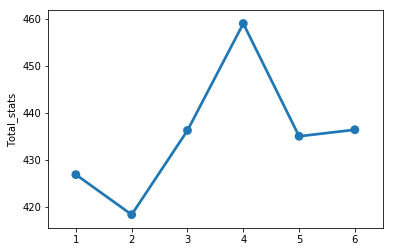

In [10]:
group_df = pokemon_df.drop(['#', 'Legendary'], axis=1)
pokemon_groups = group_df.groupby('Generation')
pokemon_groups_mean = pokemon_groups.mean()

sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Total_stats'])
plt.show()

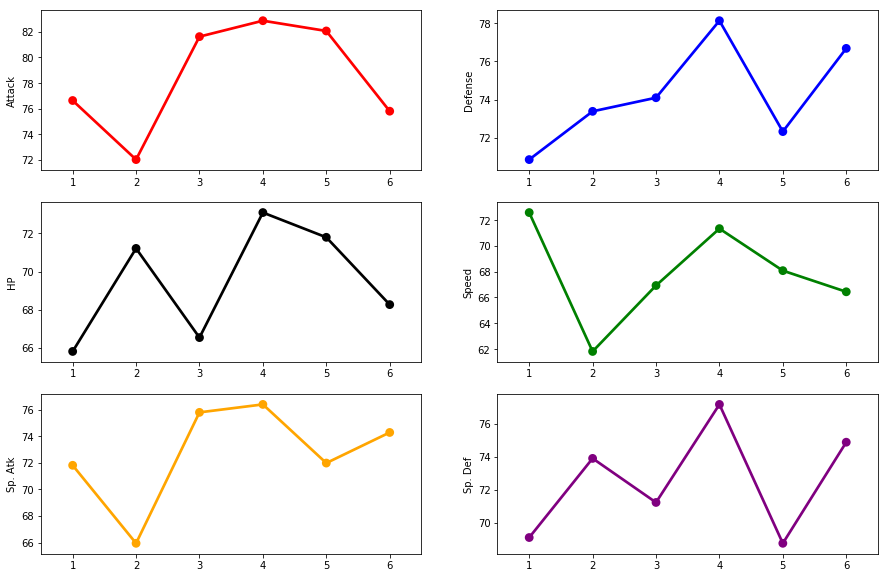

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Attack'], color='red', ax=axes[0][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Defense'], color='blue', ax=axes[0][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['HP'], color='black', ax=axes[1][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Speed'], color='green', ax=axes[1][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Sp. Atk'], color='orange', ax=axes[2][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Sp. Def'], color='purple', ax=axes[2][1])

plt.show()

In [12]:
name_dict = dict(zip(pokemon_df['#'], pokemon_df['Name']))
combats_name_df = combats_df[['First_pokemon', 'Second_pokemon', 'Winner']].replace(name_dict)
print(combats_name_df.head())

  First_pokemon Second_pokemon     Winner
0      Larvitar        Nuzleaf    Nuzleaf
1      Virizion      Terrakion  Terrakion
2       Togetic       Beheeyem   Beheeyem
3        Slugma      Druddigon  Druddigon
4       Omastar        Shuckle    Omastar


In [13]:
first_battle = combats_name_df['First_pokemon'].value_counts()
second_battle = combats_name_df['Second_pokemon'].value_counts()
win_counts = combats_name_df['Winner'].value_counts()
total_battle = first_battle + second_battle
win_percentage = win_counts / total_battle

win_percentage = win_percentage.sort_values()

In [14]:
type_df = pokemon_df.iloc[:, 0:4]
type_df = type_df.drop('Name', axis=1)
stats_df = pokemon_df.drop(['Type 1', 'Type 2', 'Name', 'Generation', 'Total_stats'], axis=1)

type_dict = type_df.set_index('#').T.to_dict('list')
stats_dict = stats_df.set_index('#').T.to_dict('list')

In [15]:
def replace_things(data):
    
    data['First_pokemon_stats'] = data.First_pokemon.map(stats_dict)
    data['Second_pokemon_stats'] = data.Second_pokemon.map(stats_dict)

    data['First_pokemon'] = data.First_pokemon.map(type_dict)
    data['Second_pokemon'] = data.Second_pokemon.map(type_dict)

    return data

In [16]:
def calculate_stats(data):
    #calculate stats difference
    
    stats_col = ['HP_diff', 'Attack_diff', 'Defense_diff', 'Sp.Atk_diff', 'Sp.Def_diff', 'Speed_diff', 'Legendary_diff']
    diff_list = []

    for row in data.itertuples():
        diff_list.append(np.array(row.First_pokemon_stats) - np.array(row.Second_pokemon_stats))

    stats_df = pd.DataFrame(diff_list, columns=stats_col)
    data = pd.concat([data, stats_df], axis=1)
    data.drop(['First_pokemon_stats', 'Second_pokemon_stats'], axis=1, inplace=True)

    return data

In [17]:
def calculate_effectiveness(data):

    '''
        this function creates a new column of each pokemon's effectiveness against it's enemy.
        every effectiveness starts with 1, if an effective type is found on enemy's type, effectiveness * 2
        if not very effective is found on enemy's type, effectiveness / 2
        if not effective is found on enemy's type, effectiveness * 0
        
        This function creates 4 new columns
            1. P1_type1, pokemon 1 first type effectiveness against the enemy's type
            2. P1_type2, pokemon 1 second type effectiveness against the enemy's type
            3. P2_type1, pokemon 2 first type effectiveness against the enemy's type
            4. P2_type2, pokemon 2 second type effectiveness against the enemy's type
    '''
    
    very_effective_dict = {'Normal': [],
                           'Fight': ['Normal', 'Rock', 'Steel', 'Ice', 'Dark'],
                           'Flying': ['Fight', 'Bug', 'Grass'],
                           'Poison': ['Grass', 'Fairy'],
                           'Ground': ['Poison', 'Rock', 'Steel', 'Fire', 'Electric'],
                           'Rock': ['Flying', 'Bug', 'Fire', 'Ice'],
                           'Bug': ['Grass', 'Psychic', 'Dark'],
                           'Ghost': ['Ghost', 'Psychic'],
                           'Steel': ['Rock', 'Ice', 'Fairy'],
                           'Fire': ['Bug', 'Steel', 'Grass', 'Ice'],
                           'Water': ['Ground', 'Rock', 'Fire'],
                           'Grass': ['Ground', 'Rock', 'Water'],
                           'Electric': ['Flying', 'Water'],
                           'Psychic': ['Fight', 'Poison'],
                           'Ice': ['Flying', 'Ground', 'Grass', 'Dragon'],
                           'Dragon': ['Dragon'],
                           'Dark': ['Ghost', 'Psychic'],
                           'Fairy': ['Fight', 'Dragon', 'Dark'],
                           'None': []}

    not_very_effective_dict = {'Normal': ['Rock', 'Steel'],
                               'Fight': ['Flying', 'Poison', 'Bug', 'Psychic', 'Fairy'],
                               'Flying': ['Rock', 'Steel', 'Electric'],
                               'Poison': ['Poison', 'Rock', 'Ground', 'Ghost'],
                               'Ground': ['Bug', 'Grass'],
                               'Rock': ['Fight', 'Ground', 'Steel'],
                               'Bug': ['Fight', 'Flying', 'Poison', 'Ghost', 'Steel', 'Fire', 'Fairy'],
                               'Ghost': ['Dark'],
                               'Steel': ['Steel', 'Fire', 'Water', 'Electric'],
                               'Fire': ['Rock', 'Fire', 'Water', 'Dragon'],
                               'Water': ['Water', 'Grass', 'Dragon'],
                               'Grass': ['Flying', 'Poison', 'Bug', 'Steel', 'Fire', 'Grass', 'Dragon'],
                               'Electric': ['Grass', 'Electric', 'Dragon'],
                               'Psychic': ['Steel', 'Psychic'],
                               'Ice': ['Steel', 'Fire', 'Water', 'Psychic'],
                               'Dragon': ['Steel'],
                               'Dark': ['Fight', 'Dark', 'Fairy'],
                               'Fairy': ['Posion', 'Steel', 'Fire'],
                               'None': []}

    not_effective_dict = {'Normal': ['Ghost'],
                          'Fight': ['Ghost'],
                          'Flying': [],
                          'Poison': ['Steel'],
                          'Ground': ['Flying'],
                          'Rock': [],
                          'Bug': [],
                          'Ghost': ['Normal'],
                          'Steel': [],
                          'Fire': [],
                          'Water': [],
                          'Grass': [],
                          'Electric': ['Ground'],
                          'Psychic': ['Dark'],
                          'Ice': [],
                          'Dragon': ['Fairy'],
                          'Dark': [],
                          'Fairy': [],
                          'None': []}

    p1_type1_list = []
    p1_type2_list = []
    p2_type1_list = []
    p2_type2_list = []

    for row in data.itertuples():
        nested_type = [[1, 1], [1, 1]]

        #manipulating values if found on dictionary
        for i in range(0,2):
            for j in range(0,2):
                if row.Second_pokemon[j] in very_effective_dict.get(row.First_pokemon[i]):
                    nested_type[0][i] *= 2
                if row.Second_pokemon[j] in not_very_effective_dict.get(row.First_pokemon[i]):
                    nested_type[0][i] /= 2
                if row.Second_pokemon[j] in not_effective_dict.get(row.First_pokemon[i]):
                    nested_type[0][i] *= 0

                if row.First_pokemon[j] in very_effective_dict.get(row.Second_pokemon[i]):
                    nested_type[1][i] *= 2
                if row.First_pokemon[j] in not_very_effective_dict.get(row.Second_pokemon[i]):
                    nested_type[1][i] /= 2
                if row.First_pokemon[j] in not_effective_dict.get(row.Second_pokemon[i]):
                    nested_type[1][i] *= 0

        p1_type1_list.append(nested_type[0][0])
        p1_type2_list.append(nested_type[0][1])
        p2_type1_list.append(nested_type[1][0])
        p2_type2_list.append(nested_type[1][1])

    data = data.assign(P1_type1=p1_type1_list, P1_type2=p1_type2_list, P2_type1=p2_type1_list, P2_type2=p2_type2_list)
    data = data.drop(['First_pokemon', 'Second_pokemon'], axis=1)

    return data

In [18]:
train_df = replace_things(combats_df)
print(train_df.head(5))
print('Each value on the list corresponds to HP, atk, def, sp.atk, sp.def, speed and legendary')

     First_pokemon   Second_pokemon  Winner            First_pokemon_stats  \
0   [Rock, Ground]    [Grass, Dark]     298    [50, 64, 50, 45, 50, 41, 0]   
1   [Grass, Fight]    [Rock, Fight]     701  [91, 90, 72, 90, 129, 108, 1]   
2  [Fairy, Flying]  [Psychic, None]     668   [55, 40, 85, 80, 105, 40, 0]   
3     [Fire, None]   [Dragon, None]     683    [40, 40, 40, 70, 40, 20, 0]   
4    [Rock, Water]      [Bug, Rock]     151  [70, 60, 125, 115, 70, 55, 0]   

            Second_pokemon_stats  
0    [70, 70, 40, 60, 40, 60, 0]  
1  [91, 129, 90, 72, 90, 108, 1]  
2   [75, 75, 75, 125, 95, 40, 0]  
3   [77, 120, 90, 60, 90, 48, 0]  
4   [20, 10, 230, 10, 230, 5, 0]  
Each value on the list corresponds to HP, atk, def, sp.atk, sp.def, speed and legendary


In [19]:
train_df = calculate_stats(train_df)
print(train_df.head(5))
print('Each first pokemon\'s stats are then subtracted by the second pokemon\'s stats')
print('Positive values implies the first pokemon has higher stats and vice versa.')

     First_pokemon   Second_pokemon  Winner  HP_diff  Attack_diff  \
0   [Rock, Ground]    [Grass, Dark]     298      -20           -6   
1   [Grass, Fight]    [Rock, Fight]     701        0          -39   
2  [Fairy, Flying]  [Psychic, None]     668      -20          -35   
3     [Fire, None]   [Dragon, None]     683      -37          -80   
4    [Rock, Water]      [Bug, Rock]     151       50           50   

   Defense_diff  Sp.Atk_diff  Sp.Def_diff  Speed_diff  Legendary_diff  
0            10          -15           10         -19               0  
1           -18           18           39           0               0  
2            10          -45           10           0               0  
3           -50           10          -50         -28               0  
4          -105          105         -160          50               0  
Each first pokemon's stats are then subtracted by the second pokemon's stats
Positive values implies the first pokemon has higher stats and vice versa.


In [20]:
train_df = calculate_effectiveness(train_df)
print(train_df.head())

   Winner  HP_diff  Attack_diff  Defense_diff  Sp.Atk_diff  Sp.Def_diff  \
0     298      -20           -6            10          -15           10   
1     701        0          -39           -18           18           39   
2     668      -20          -35            10          -45           10   
3     683      -37          -80           -50           10          -50   
4     151       50           50          -105          105         -160   

   Speed_diff  Legendary_diff  P1_type1  P1_type2  P2_type1  P2_type2  
0         -19               0       1.0       0.5       4.0       1.0  
1           0               0       2.0       2.0       0.5       1.0  
2           0               0       1.0       1.0       1.0       1.0  
3         -28               0       0.5       1.0       1.0       1.0  
4          50               0       2.0       2.0       1.0       1.0  


In [21]:
y_train_full = train_df['Winner']
x_train_full = train_df.drop('Winner', axis=1)

from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

clf_dict = {'log reg': LogisticRegression(), 
            'naive bayes': GaussianNB(), 
            'random forest': RandomForestClassifier(n_estimators=100),
            'knn': KNeighborsClassifier(),
            'linear svc': LinearSVC(),
            'ada boost': AdaBoostClassifier(n_estimators=100),
            'gradient boosting': GradientBoostingClassifier(n_estimators=100),
            'CART': DecisionTreeClassifier()}

for name, clf in clf_dict.items():
    model = clf.fit(x_train, y_train)
    pred = model.predict(x_cv)
    print('Accuracy of {}:'.format(name), accuracy_score(pred, y_cv))

In [ ]:
test_df = replace_things(test_df)
test_df = calculate_stats(test_df)
test_df = calculate_effectiveness(test_df)
print(test_df.head())

In [ ]:
classifier = RandomForestClassifier(n_estimators=100)
model = classifier.fit(x_train_full, y_train_full)
prediction = model.predict(test_df)

#prediction_df is created at the very beginning, it's the same thing as test_df before it's changed.
prediction_df['Winner'] = prediction
prediction_df['Winner'][prediction_df['Winner'] == 0] = prediction_df['First_pokemon']
prediction_df['Winner'][prediction_df['Winner'] == 1] = prediction_df['Second_pokemon']
print(prediction_df)

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #Note that 17 is the number of columns in the input matrix. 
        self.fc1 = nn.Linear(18, 270)
        #270 is arbitrary, but needs to be consistent.  2 is the number of classes in the output (died/survived)
        self.fc2 = nn.Linear(270, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)  #signmoid flattens to probability 0-1. 
        
        return x
    
net = Net()